In [15]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# === Chargement d'image ===
def image_load(path, channel=3):
    assert os.path.exists(path), " Chemin invalide"
    if channel == 1:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif channel == 3:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        raise ValueError("channel doit être 1 (Grayscale) ou 3 (RGB)")
    assert image is not None, " Échec du chargement"
    return image

In [16]:
# === Convolution ===
def convolve_channel(image, kernel, pad_mode='reflect'):
    kh, kw = kernel.shape
    ih, iw = image.shape
    assert ih >= kh and iw >= kw, "Image trop petite pour le noyau"
    pad_h, pad_w = kh // 2, kw // 2
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode=pad_mode)
    output = np.zeros_like(image, dtype=np.float32)
    for i in range(ih):
        for j in range(iw):
            region = padded[i:i+kh, j:j+kw]
            output[i, j] = np.sum(region * kernel)
    return output

def apply_convolution(image, kernel, pad_mode='reflect'):
    assert isinstance(image, np.ndarray)
    assert isinstance(kernel, np.ndarray)
    assert kernel.shape[0] == kernel.shape[1] and kernel.shape[0] % 2 == 1
    if len(image.shape) == 3:
        assert image.shape[2] == 3
        output = np.zeros_like(image, dtype=np.float32)
        for c in range(3):
            output[:, :, c] = convolve_channel(image[:, :, c], kernel, pad_mode)
    else:
        output = convolve_channel(image, kernel, pad_mode)
    return np.clip(output, 0, 255).astype(np.uint8)

In [17]:
# === Affichage multiple ===
def display_all_filters(title, original, filtered_dict):
    n = len(filtered_dict) + 1
    plt.figure(figsize=(4 * n, 5))
    plt.subplot(1, n, 1)
    plt.title("Original")
    plt.imshow(original, cmap='gray' if len(original.shape) == 2 else None)
    plt.axis('off')
    for i, (name, img) in enumerate(filtered_dict.items()):
        plt.subplot(1, n, i + 2)
        plt.title(name)
        plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# === Filtres prédéfinis ===
blur_kernel = np.ones((3, 3)) / 9

sobel_horizontal = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

sobel_vertical = np.array([
    [-1, -2, -1],
    [0,  0,  0],
    [1,  2,  1]
])

sharpen_kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

laplacian_kernel = np.array([
    [0,  1, 0],
    [1, -4, 1],
    [0,  1, 0]
])

emboss_kernel = np.array([
    [-2, -1,  0],
    [-1,  1,  1],
    [ 0,  1,  2]
])

np.random.seed(42)
random_kernel = np.random.rand(3, 3) - 0.5


 Traitement de : image1.PNG


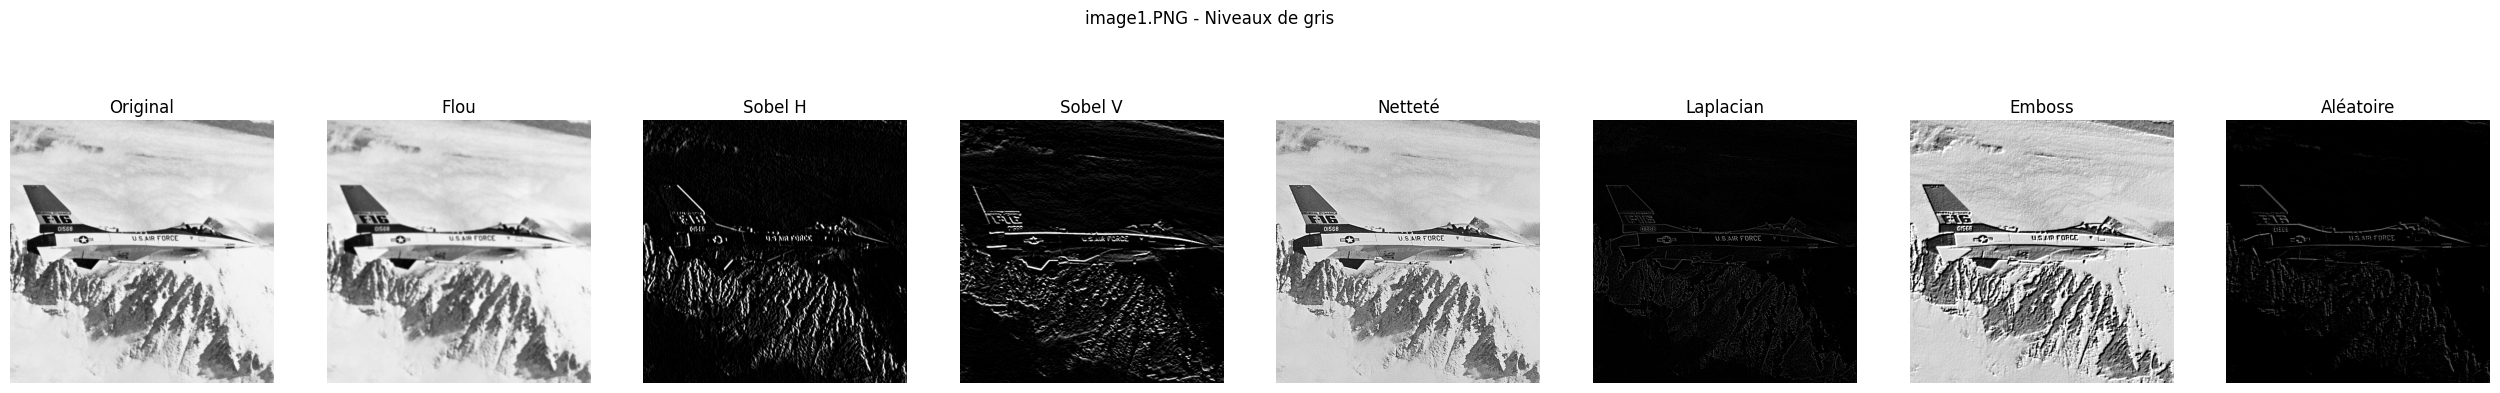

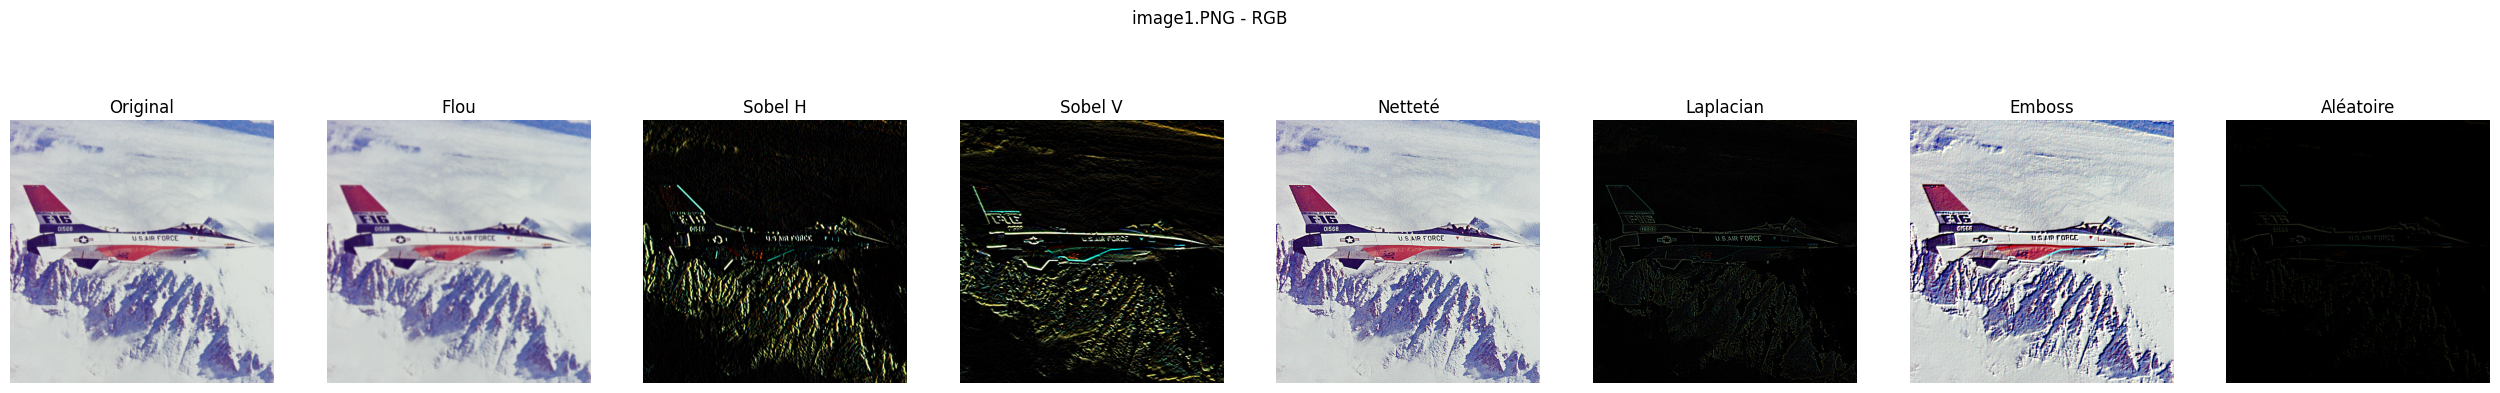

 Traitement de : image2.PNG


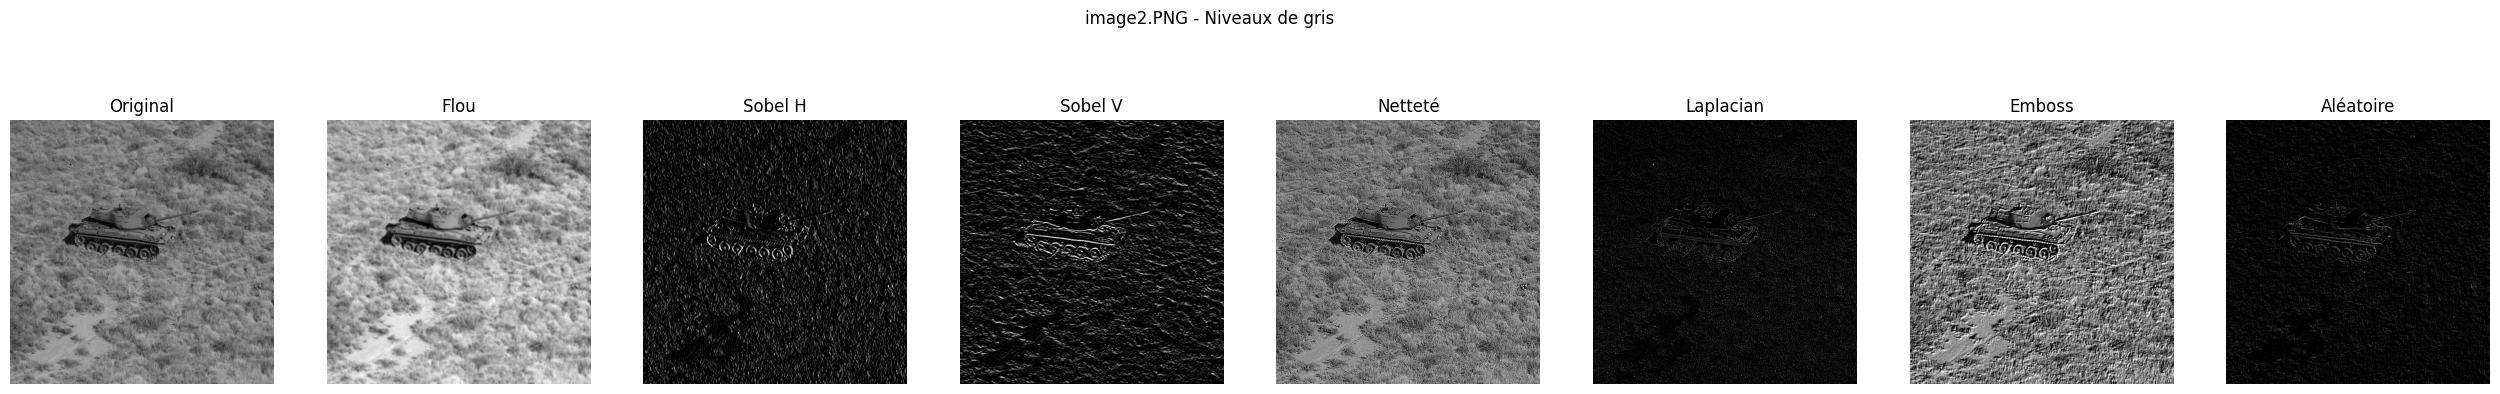

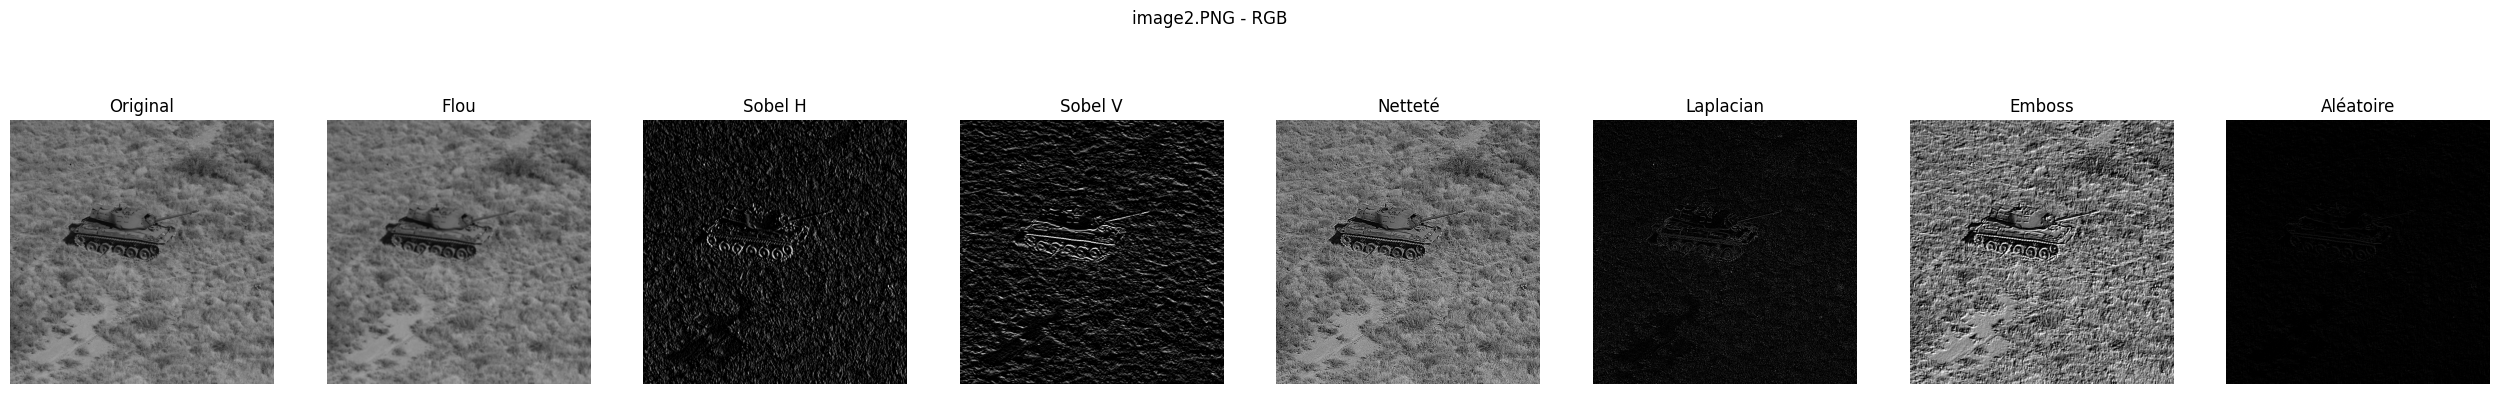

 Traitement de : image3.PNG


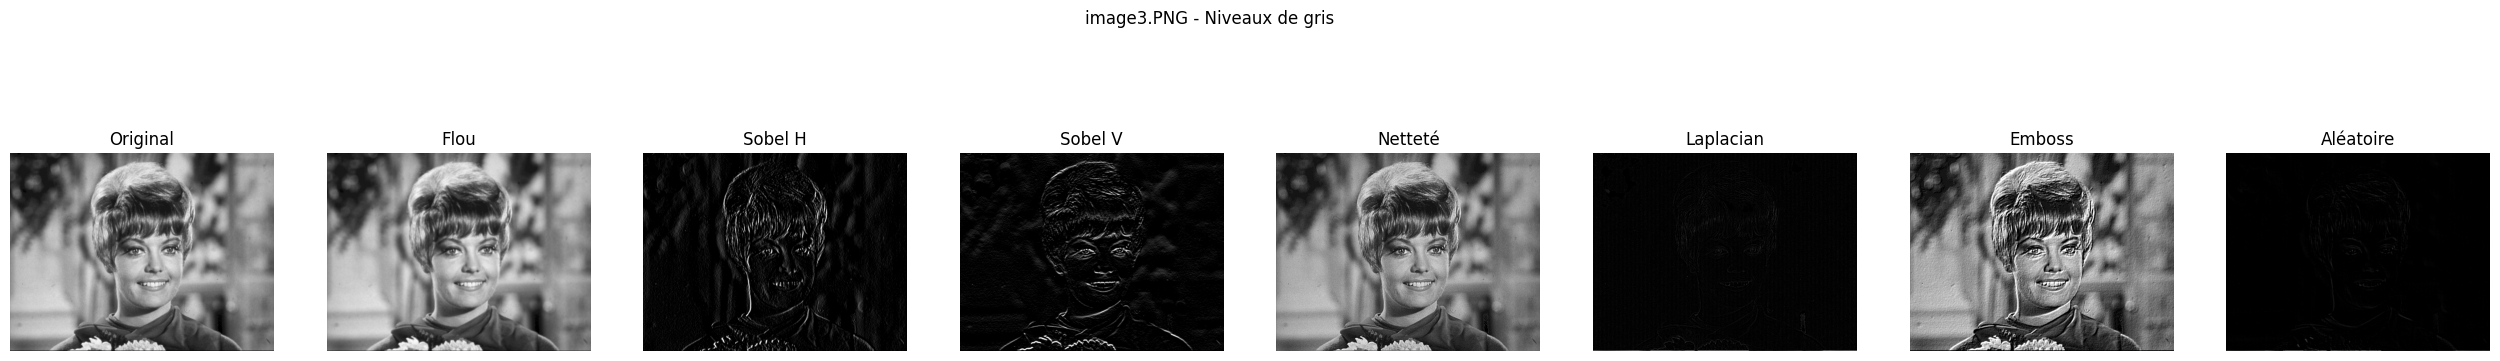

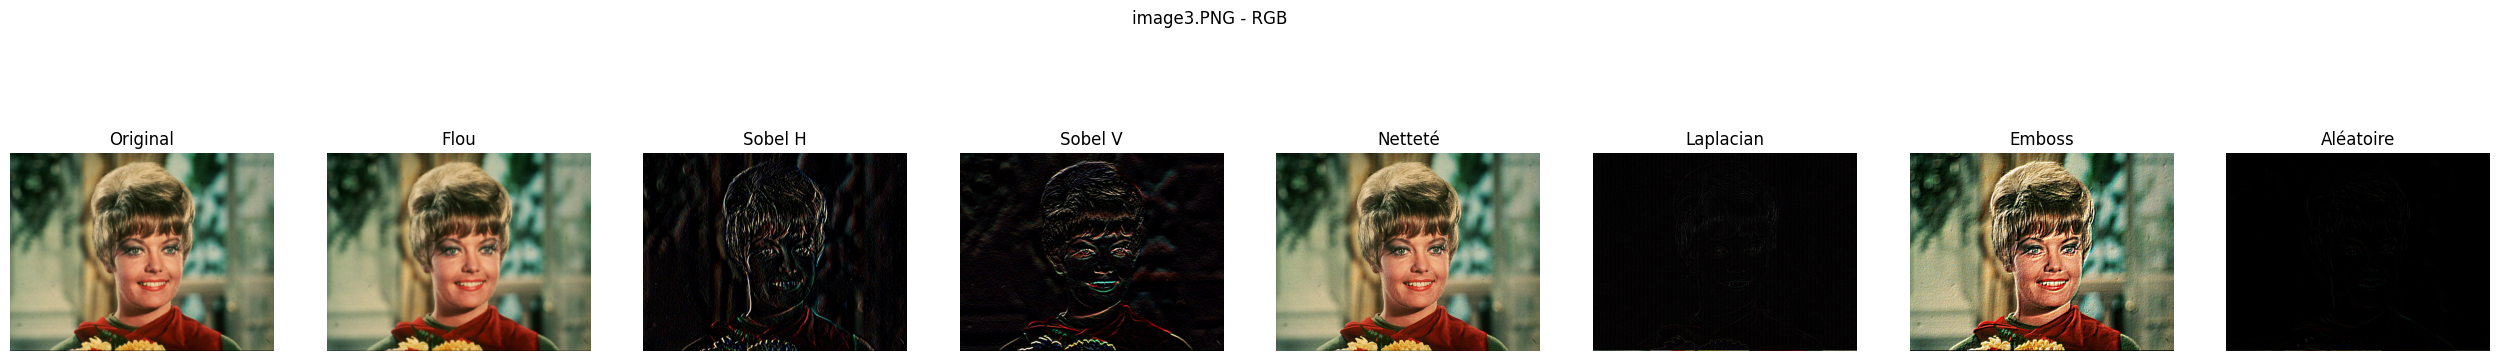

In [18]:
# === Liste de filtres ===
filters = {
    "Flou": blur_kernel,
    "Sobel H": sobel_horizontal,
    "Sobel V": sobel_vertical,
    "Netteté": sharpen_kernel,
    "Laplacian": laplacian_kernel,
    "Emboss": emboss_kernel,
    "Aléatoire": random_kernel
}

# === Charger l'image ===
# === Liste des noms d’images à traiter ===
image_list = ["image1.PNG", "image2.PNG", "image3.PNG"]

# === Appliquer les filtres à chaque image ===
for image_name in image_list:
    print(f" Traitement de : {image_name}")

    # Chemin complet si nécessaire
    image_path = os.path.join(os.getcwd(), image_name)

    # Charger l'image en niveaux de gris et RGB
    gray_image = image_load(image_path, channel=1)
    rgb_image = image_load(image_path, channel=3)

    # Appliquer les filtres
    gray_results = {name: apply_convolution(gray_image, kernel) for name, kernel in filters.items()}
    rgb_results = {name: apply_convolution(rgb_image, kernel) for name, kernel in filters.items()}

    # Afficher les résultats
    display_all_filters(f"{image_name} - Niveaux de gris", gray_image, gray_results)
    display_all_filters(f"{image_name} - RGB", rgb_image, rgb_results)

    # Sauvegarder les résultats
    base_name = os.path.splitext(image_name)[0]
    for name, img in gray_results.items():
        outname = f"{base_name}_{name.lower().replace(' ', '_')}_gray.jpg"
        cv2.imwrite(outname, img)

    for name, img in rgb_results.items():
        outname = f"{base_name}_{name.lower().replace(' ', '_')}_rgb.jpg"
        cv2.imwrite(outname, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
